# Plotly Demo Examples

Jupyter notebook accompanying ACB BroadRATS talk given by Conor Messer on December 2, 2021 about interactive plotting
using the python Plotly package. Feel free to reach out to Conor at cmesser@broadinstitute.org with questions about
the package or the code.

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

# Simple Examples

## Plotly Express

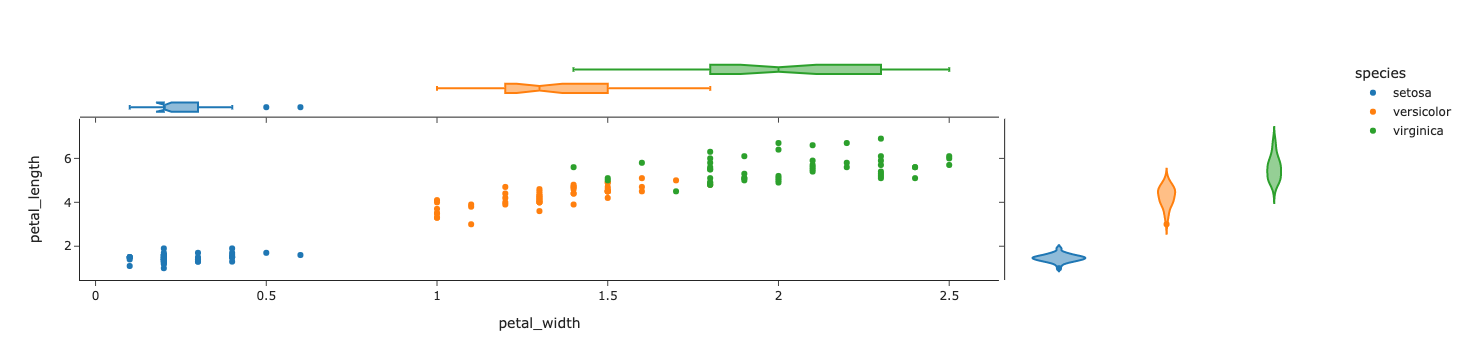

In [57]:
df = px.data.iris()  # reads in data as pandas dataframe
fig = px.scatter(df, x="petal_width", y="petal_length", color="species", marginal_y="violin",
                 marginal_x="box", template="simple_white", hover_data=["sepal_width", "sepal_length"])
fig.show()

### Update Layout - figure size, title

In [58]:
type(fig)

plotly.graph_objs._figure.Figure

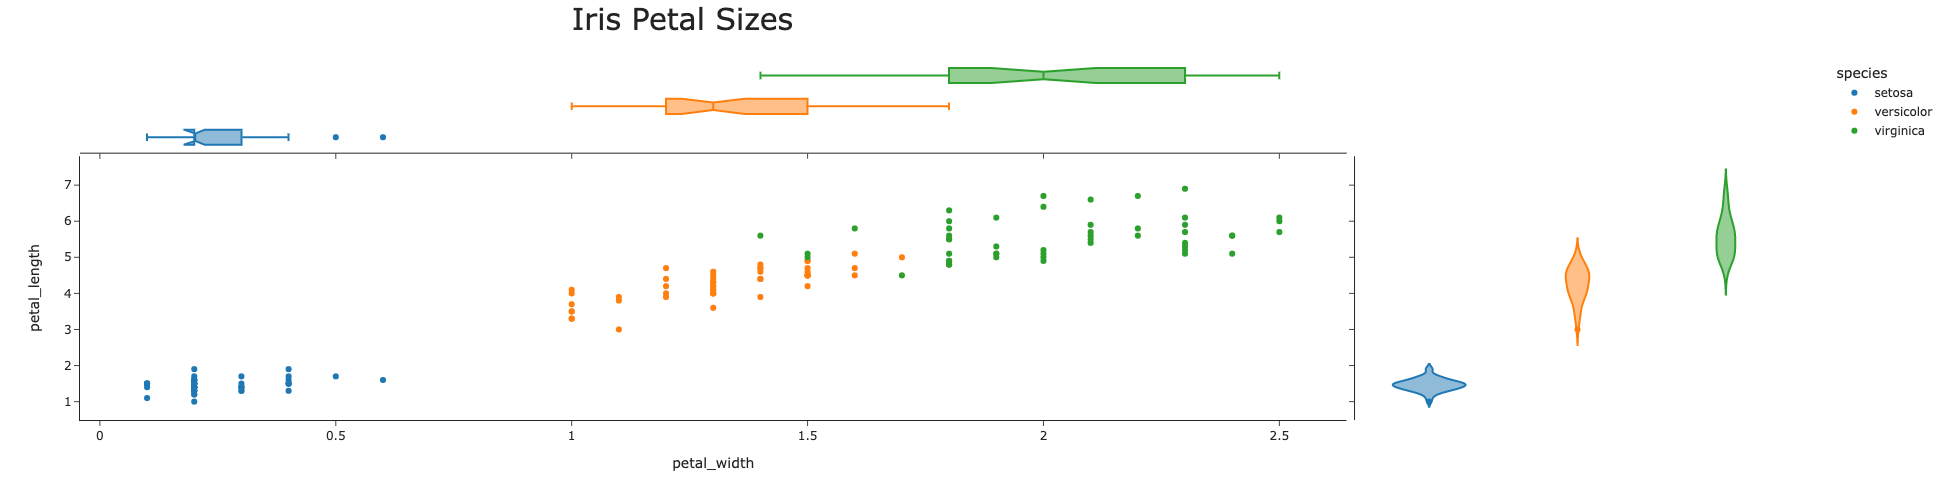

In [3]:
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
    title={'text':'Iris Petal Sizes',
           'font_size':30,
           'xanchor':'center',
          'x':0.35}
)
fig.show()

### Add highlighting boxes to plot

There is an add_trace method to add additional plot types or additional series to the figure. There are also many helper methods for adding specific types of lines, shapes, annotations, etc.

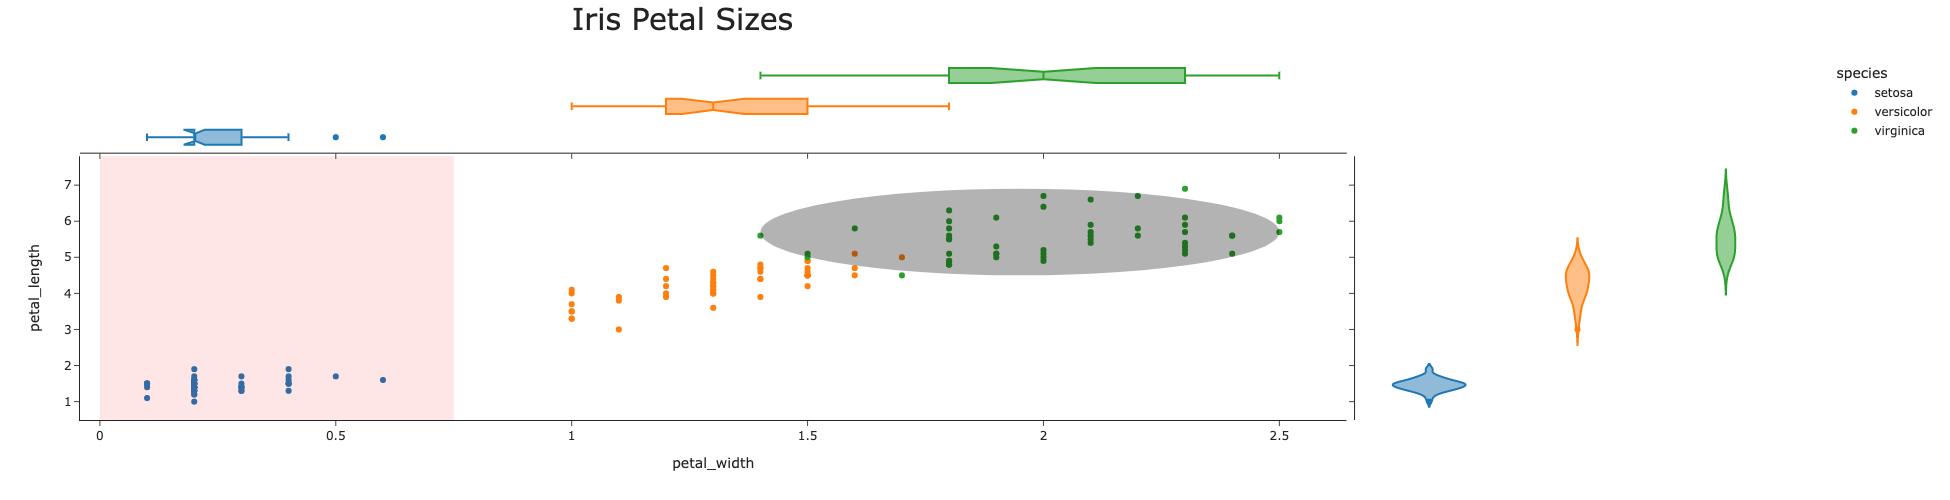

In [4]:
fig.add_vrect(0, 0.75, fillcolor='red', opacity=0.1, col=1, row=1)
fig.add_shape(type='circle', 
              x0=min(df[df['species'] == 'virginica']['petal_width']), 
              x1=max(df[df['species'] == 'virginica']['petal_width']), 
              y0=min(df[df['species'] == 'virginica']['petal_length']), 
              y1=max(df[df['species'] == 'virginica']['petal_length']), 
              line_color='green')
fig.show()

# RNASeq - Differential Expression
## Sample QC

Sample types and sources represent many covariates that need to be controlled for in RNASeq Differential Expression analysis. Though they can be adjusted for using SmartSeq and other tools, it is a good idea to visualize the quality metrics for your samples to remove the worst outliers.

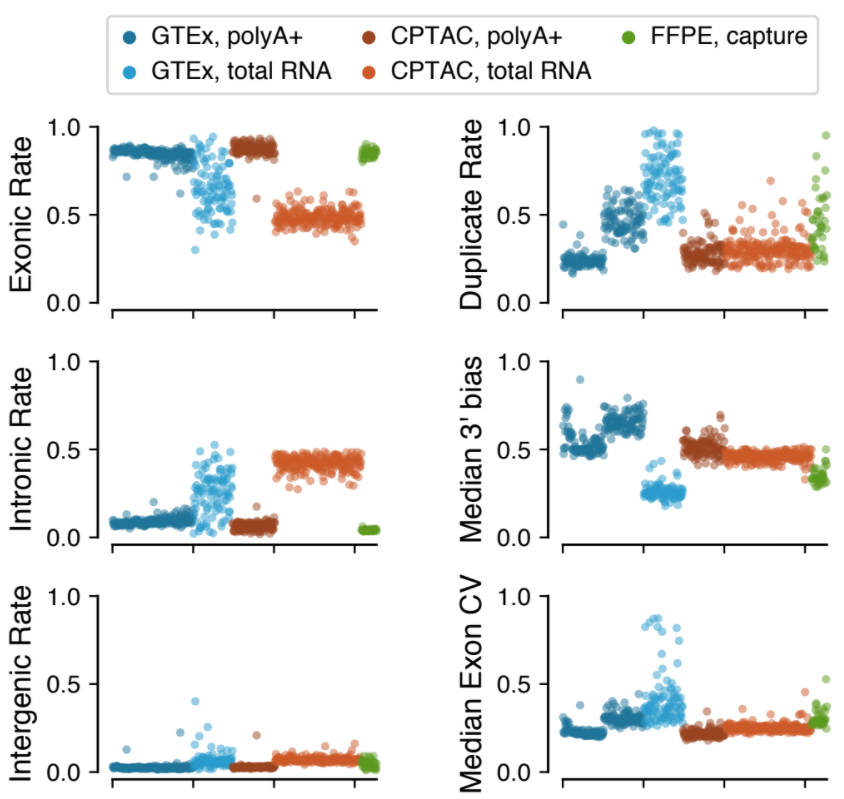

In [65]:
from IPython.display import Image
Image(filename='./data/metrics_figure.png') # from Graubert, et al. RNA-SeQC 2: efficient RNA-seq quality control and quantification for large cohorts

In [7]:
# read in sample QC metrics from pickle file
metrics = pd.read_pickle('./data/rnaseQC_metrics.pickle')

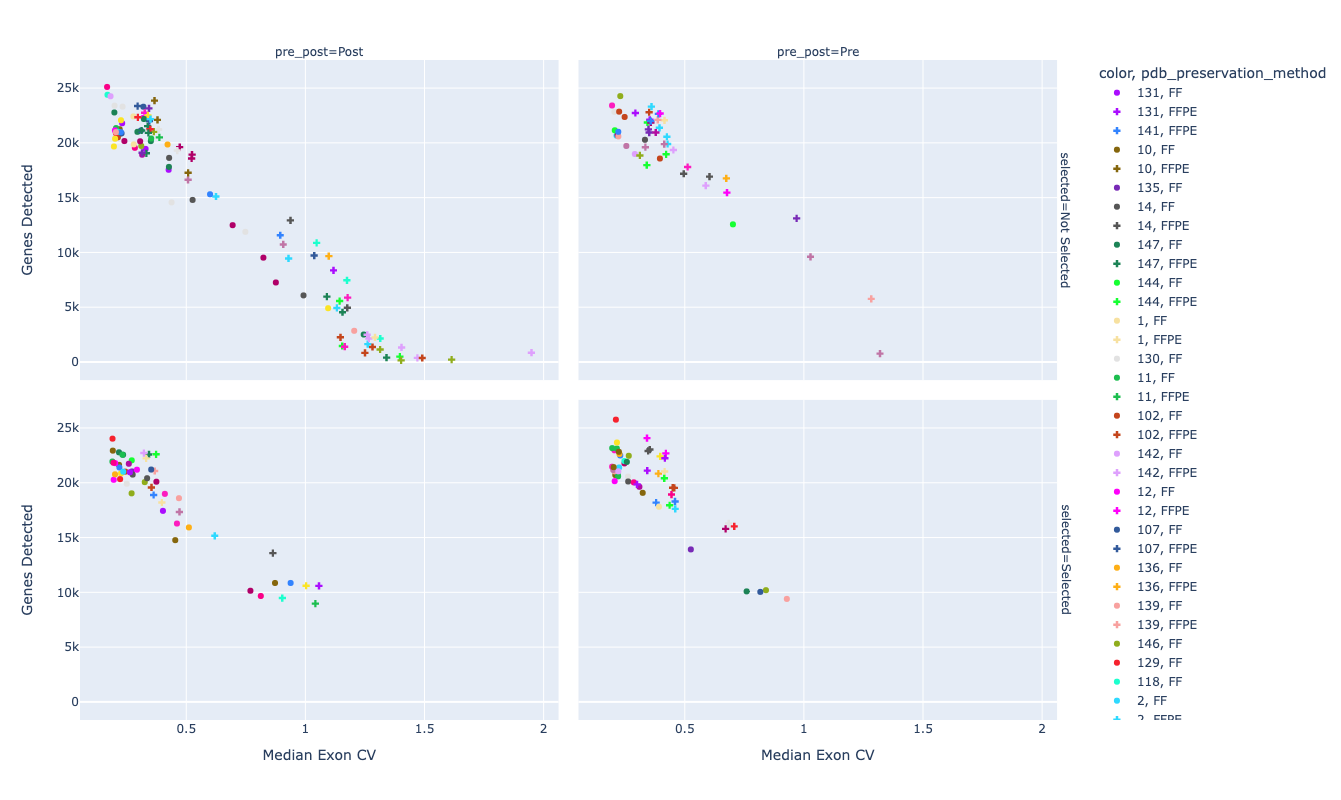

In [62]:
from helper_funcs import choose_samples  # method to simplify choosing samples based on criteria

selected_samples = choose_samples(metrics, gt={'Genes Detected': 6000})
metrics_df = metrics.copy()

metrics_df['selected'] = metrics_df.index.map(lambda s: 'Selected' if s in selected_samples else 'Not Selected')
metrics_df['participant_int'] = metrics_df['participant'].str.extract('GBM.ICB-([0-9]+)', expand=False)
fig = metrics_df.reset_index().plot.scatter('Median Exon CV', 'Genes Detected',
                                            color=list(metrics_df['participant_int']),
                                            color_discrete_sequence=px.colors.qualitative.Alphabet,
                                            symbol='pdb_preservation_method', symbol_sequence=['circle', 'cross'],
                                            backend='plotly',
                                            facet_col='pre_post', facet_row='selected',
                                            hover_data=['pre_post', 'participant', 'index', 'pdb_preservation_method', 'dftx_start', 'dftx_end', 'selected'],
                                            height=800)
fig.show()

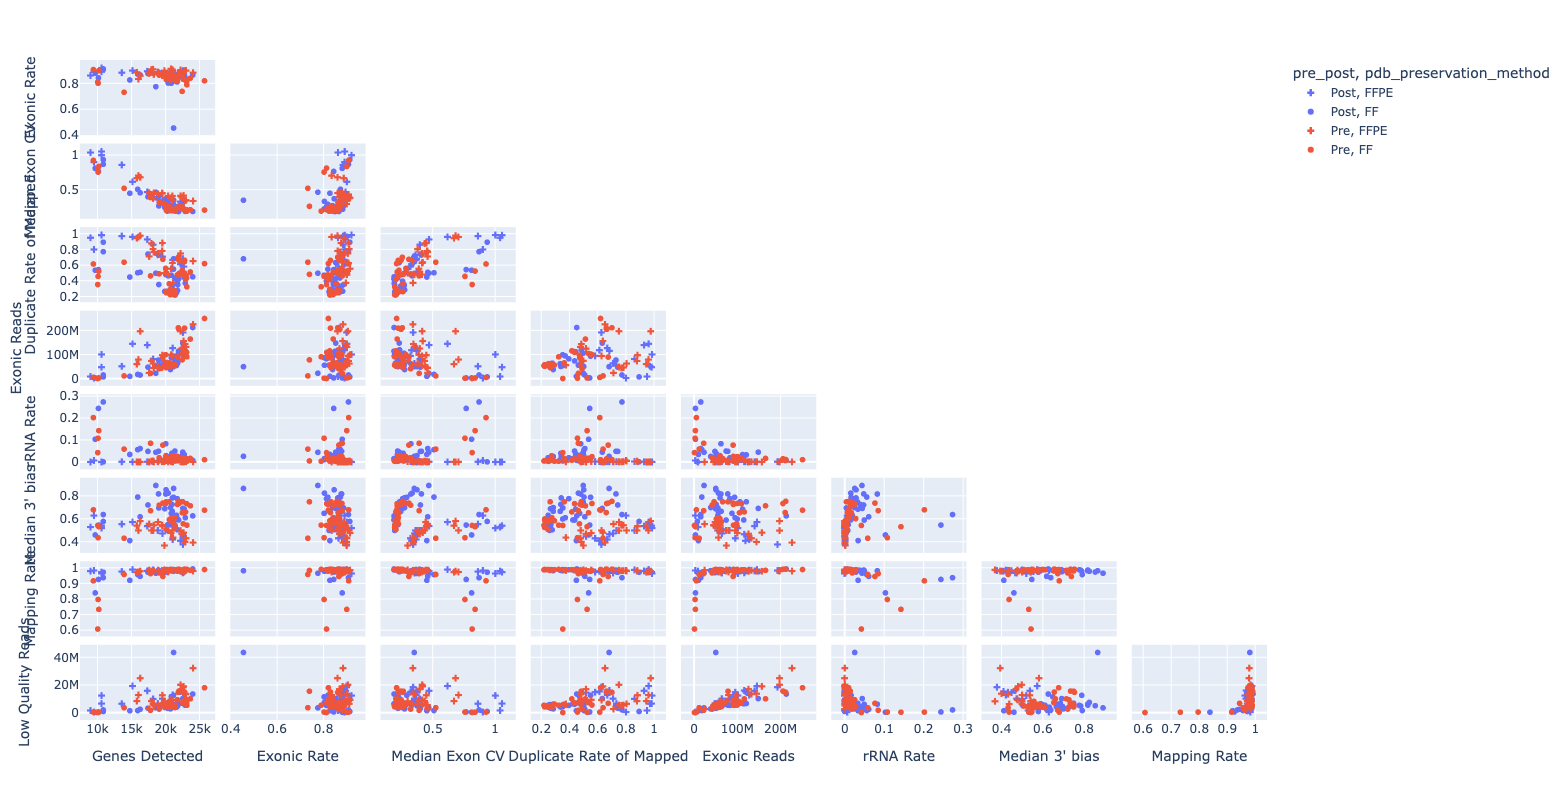

In [22]:
metrics_list = ['Genes Detected', 'Exonic Rate', 'Median Exon CV',
                'Duplicate Rate of Mapped', 'Exonic Reads','rRNA Rate', 
                "Median 3' bias", 'Mapping Rate', 'Low Quality Reads']
sample_metrics = metrics_df.loc[selected_samples]
fig = px.scatter_matrix(sample_metrics.reset_index(), dimensions=metrics_list, color='pre_post', 
                        symbol='pdb_preservation_method', symbol_sequence=['cross', 'circle'],
                        hover_data=['index', 'pdb_preservation_method'])
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.update_layout(height=800)
fig.show()

## Displaying results of Differential Expression Analysis
### Volcano Plot (taken from https://plotly.com/python/volcano-plot/)

In [ ]:
import dash_bio as dashbio

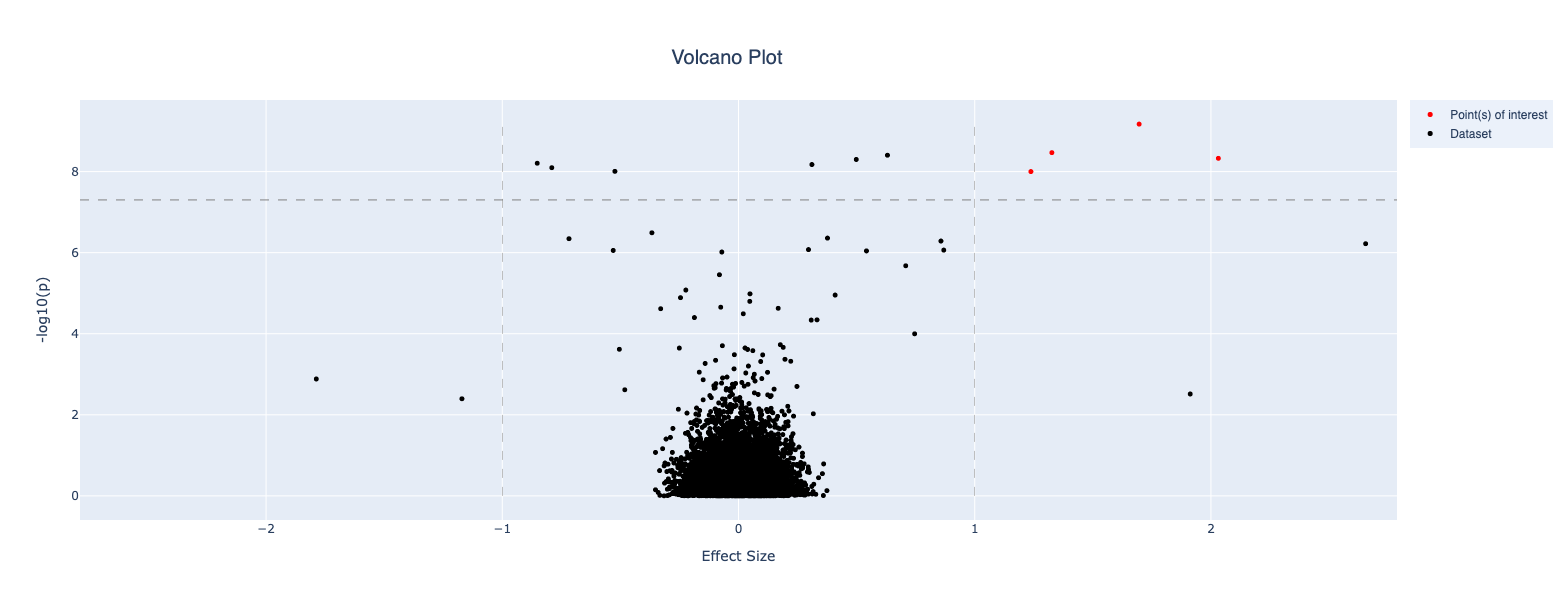

In [24]:
df = pd.read_csv('https://git.io/volcano_data1.csv')
fig = dashbio.VolcanoPlot(
    dataframe=df,
)
fig.update_layout(height=600, width=800)

### Volcano Plot with additional colors

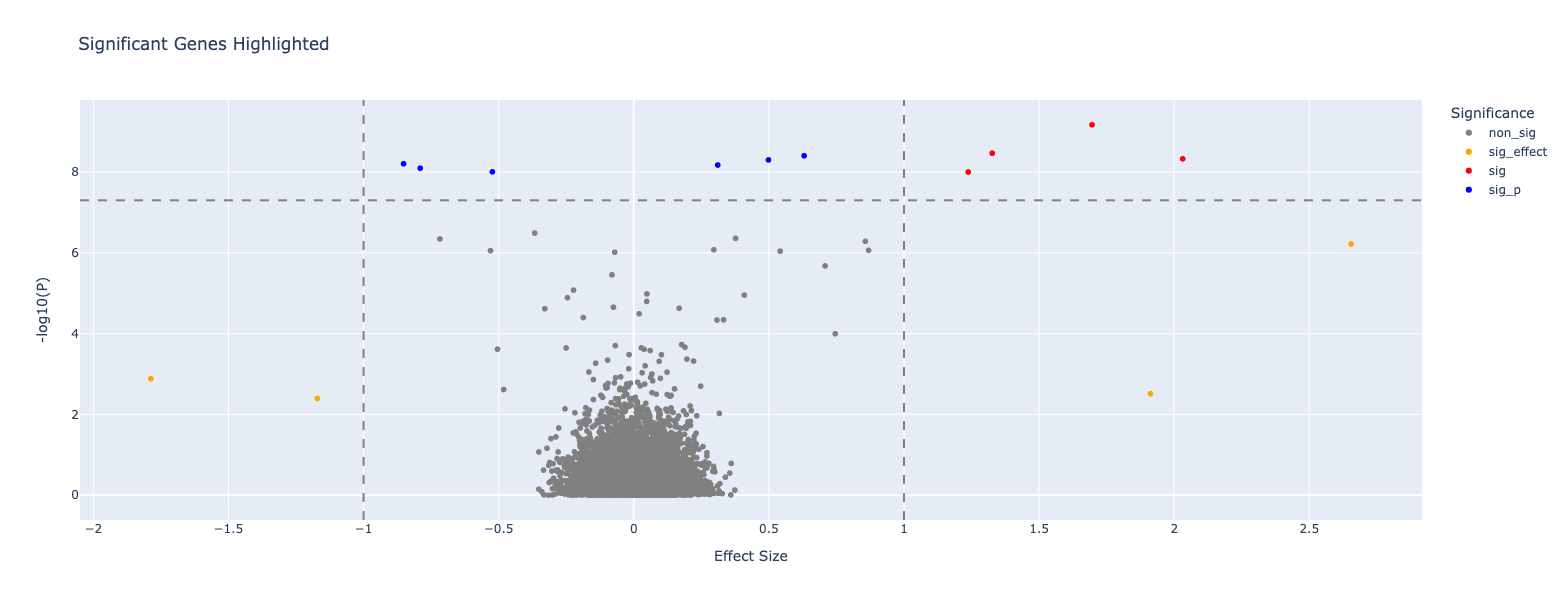

In [56]:
def assign_color(p_val, p_cutoff, effect_size, eff_cutoff):
    if p_val < p_cutoff and abs(effect_size) > eff_cutoff:
        return 'sig'
    elif p_val < p_cutoff:
        return 'sig_p'
    elif abs(effect_size) > eff_cutoff:
        return 'sig_effect'
    else:
        return 'non_sig'
    
color_map = {'sig': 'red', 'sig_p': 'blue', 'sig_effect': 'orange', 'non_sig': 'gray'}
p_sig_val = 0.00000005

df['color'] = df.apply(lambda x: assign_color(x['P'], p_sig_val, x['EFFECTSIZE'], 1), axis=1)
df['neg_log_p'] = df['P'].apply(lambda x: -np.log10(x))
fig = df.plot.scatter(x='EFFECTSIZE', y='neg_log_p', 
                      color='color', color_discrete_map=color_map, 
                      backend='plotly', 
                      labels={
                          "EFFECTSIZE": "Effect Size",
                          "neg_log_p": "-log10(P)",
                          "color": "Significance"},
                      hover_data=['GENE', 'P', 'ZSCORE'],
                      title='Significant Genes Highlighted')
fig.add_hline(y=-np.log10(p_sig_val), line_dash="dash", line_color='gray')
fig.add_vline(x=-1, line_dash="dash", line_color='gray')
fig.add_vline(x=1, line_dash="dash", line_color='gray')

fig.update_layout(height=600, width=800)
fig.show()

# Exploring Genomic Data
## Mutations overlaid on Copy Number Plot

Data is protected, so the results have been removed. Can be re-run with mut_ccfs file (output from phylogic), seg files for each sample and a seg_clusters file from a different cohort.

In [ ]:
from dalmatian.wmanager import WorkspaceManager
from helper_funcs import calculate_error, get_tree_data, get_seg_tree
import re

#### Maf dataframe prep

In [ ]:
workspace_name='name_space/work_space'
wm = WorkspaceManager(workspace_name)
all_pairs = wm.get_pairs()
all_participants = wm.get_participants()

In [ ]:
mut_ccfs_file = 'gs://bucket/phylogicndt/participant_name.mut_ccfs.txt'
seg_files = ["gs://bucket/CGA_Production_Analysis_Workflow//call-gatk_acnv_only/results/Sample_1.tsv", "gs://bucket/CGA_Production_Analysis_Workflow//call-gatk_acnv_only/results/Sample_2.tsv"]
seg_clusters_file = 'gs://bucket/assign_segs/call-call_seg_clusters/participant_name.seg_assignments.txt'

pmf_headers = [f'preDP_ccf_{str(n/100)}' for n in range(1,100)]
pmf_headers = ['preDP_ccf_0.0'] + pmf_headers + ['preDP_ccf_1.0']

maf_df = pd.read_csv(mut_ccfs_file, sep='\t')
sample_names_trunc = maf_df['Sample_ID'].apply(lambda x: re.search('(?<=ICB-)\d.+(_Post|_Pre)\d*', x)[0])
maf_df.insert(2, 'sample', sample_names_trunc)

# calculate VAF
vaf = maf_df['t_alt_count'] / \
      (maf_df['t_alt_count'] + maf_df['t_ref_count'])
maf_df.insert(10, 'VAF', vaf)

clean_mafs = maf_df
numeric_chrom = maf_df['Chromosome']
numeric_chrom = numeric_chrom.replace('X', '23')
clean_mafs['Chromosome'] = numeric_chrom
clean_mafs = clean_mafs.astype({'Chromosome':int})
clean_mafs.sort_values(['sample', 'Chromosome', 'Start_position'], inplace=True)

#### Copy Number Profiles

In [ ]:
all_segs = {}
sample_names = []
for fn in list(seg_files):
    capseg_df = pd.read_csv(fn, sep='\t')
    sample_name = re.match('.+OnPrem', fn.split('/')[-1])[0]
    sample_names.append(sample_name)
    all_segs[sample_name] = capseg_df

In [ ]:
seg_cluster_df = pd.read_csv(seg_clusters_file, sep='\t')

seg_dict = {sample:all_segs[sample] for sample in sample_names}
this_seg_tree = get_seg_tree(seg_dict, seg_cluster_df)

In [ ]:
# add CNV information to all_mafs df
# fills in missing seg data with 'NA - no seg'
clean_mafs['mu_minor'] = clean_mafs.apply(lambda x: get_tree_data(this_seg_tree, x.Chromosome,
                                                                  x.Start_position, x.Sample_ID, 0), axis=1)
clean_mafs['mu_major'] = clean_mafs.apply(lambda x: get_tree_data(this_seg_tree, x.Chromosome,
                                                                  x.Start_position, x.Sample_ID, 1), axis=1)
clean_mafs['sigma_minor'] = clean_mafs.apply(lambda x: get_tree_data(this_seg_tree, x.Chromosome,
                                                                     x.Start_position, x.Sample_ID, 2), axis=1)
clean_mafs['sigma_major'] = clean_mafs.apply(lambda x: get_tree_data(this_seg_tree, x.Chromosome,
                                                                     x.Start_position, x.Sample_ID, 3), axis=1)
# fill in remaining nan's that had a segment but with zero het sites
# consider pulling in total CN value, even though no allelic information
clean_mafs['mu_minor'] = clean_mafs['mu_minor'].fillna('NA - zero hets')
clean_mafs['mu_major'] = clean_mafs['mu_major'].fillna('NA - zero hets')
clean_mafs['sigma_minor'] = clean_mafs['sigma_minor'].fillna('NA - zero hets')
clean_mafs['sigma_major'] = clean_mafs['sigma_major'].fillna('NA - zero hets')

In [ ]:
# get purity and ploidy for all samples - from Terra workspace or hardcoded

all_purity = [0.53, 0.7]
all_ploidy = [2.29, 1.97]
sample_dates = [84, 574]
sample_order = {s:date for s, date in zip(sample_names, sample_dates)}

In [ ]:
figs = []

cr_diff_dict = {}
c0_dict = {}
purity_dict = {}
for i, sample in enumerate(sample_names):
    this_pair = sample + '_pair'
    purity = all_purity[i]
    ploidy = all_ploidy[i]

    seg = all_segs[sample].dropna(subset=['length', 'mu.minor', 'mu.major'])
    cr_diff = ((seg['mu.minor'] * seg['length']).sum() + (seg['mu.major'] * seg['length']).sum()) / \
          (ploidy * seg['length'].sum() - (1 - 1 / purity) * seg['length'].sum() * 2)

    # Get copy ratio for copy number = 0
    c0 = (cr_diff / purity) - cr_diff

    cr_diff_dict[sample] = cr_diff
    c0_dict[sample] = c0
    purity_dict[sample] = purity
    
#sample_df = clean_mafs.copy()

# should deal with these still - how to plot them without allelic info?
clean_mafs = clean_mafs[~clean_mafs['mu_major'].isin(['NA - no seg', 'NA - zero hets'])]
clean_mafs['mu_major_adj'] = clean_mafs['mu_major'].apply(lambda x: (x - c0) / cr_diff)
clean_mafs['mu_minor_adj'] = clean_mafs['mu_minor'].apply(lambda x: (x - c0) / cr_diff)

clean_mafs['multiplicity_ccf'] = clean_mafs.apply(lambda x: x.VAF * (purity * (x.mu_major_adj + x.mu_minor_adj) +
                                                                   2 * (1 - purity)) / purity, axis=1)

# calculate error bars for mutations
clean_mafs['error_top'] = clean_mafs.apply(lambda x: calculate_error(x.t_alt_count, x.t_ref_count, purity, 0.975), axis=1)
clean_mafs['error_bottom'] = clean_mafs.apply(lambda x: -1 * calculate_error(x.t_alt_count, x.t_ref_count, purity, 0.025), axis=1)

# Testing mut/seg plot
import importlib
import helper_funcs
importlib.reload(helper_funcs)
from helper_funcs import make_mut_seg_plot

clean_mafs['marker_size'] = 1
clean_mafs['Cluster_Assignment'] = clean_mafs['Cluster_Assignment'].astype(str)


#### Get static subplots

In [ ]:
fig, seg_df, seg_traces = make_mut_seg_plot(clean_mafs, this_seg_tree, sample_order, cr_diff_dict, c0_dict)


In [ ]:
fig.show()

### Add Widgets

In [ ]:
from ipywidgets import widgets
import plotly.graph_objs as go

In [ ]:
fig.layout.height = 1000

mutation_uncertainty = widgets.Checkbox(
    value=True,
    description='Plot uncertainty of the mutations',
    disabled=False,
    indent=False
)

cnv_uncertainty = widgets.Checkbox(
    value=False,
    description='Plot uncertainty of the CNVs',
    disabled=False,
    indent=False
)

zero_VAF_muts = widgets.Checkbox(
    value=True,
    description='Allow plotting of mutations with 0 VAF',
    disabled=False,
    indent=False
)

var_class = clean_mafs['Variant_Classification'].unique().tolist()
class_select = widgets.SelectMultiple(
    options=var_class,
    value=var_class,
    description='Variant Classes:  ',
    disabled=False
)

var_type = clean_mafs['Variant_Type'].unique().tolist()
type_select = widgets.SelectMultiple(
    options=var_type,
    value=var_type,
    description='Mutation Types:  ',
    disabled=False
)

clusters = clean_mafs['Cluster_Assignment'].unique().tolist()
cluster_select = widgets.SelectMultiple(
    options=clusters,
    value=clusters,
    description='Mutation Clusters:  ',
    disabled=False
)

ipython_fig = go.FigureWidget(fig)
color_scale = helper_funcs.get_phylogic_color_scale()
df_w_filter = clean_mafs.copy()

def response(change):
    filter_list = [c in class_select.value and
                   t in type_select.value and
                   cluster in cluster_select.value and
                   (zero_VAF_muts.value or v > 0)
                   for c, t, v, cluster in zip(clean_mafs['Variant_Classification'],
                                               clean_mafs['Variant_Type'],
                                               clean_mafs['VAF'],
                                               clean_mafs['Cluster_Assignment'])]
    df_w_filter['filter'] = filter_list

    temp_df = clean_mafs[filter_list]
    mut_colors = [color_scale[str(c)] for c in list(temp_df['Cluster_Assignment'])]

    with ipython_fig.batch_update():
        # update mutation scatter plot with filtered values
        sample_order_real = sorted(sample_order, key=lambda k: sample_order[k])

        for row, sample in enumerate(sample_order_real):
            this_sample_df = temp_df[temp_df['Sample_ID'] == sample]
            ipython_fig.update_traces(x=this_sample_df['x_loc'],
                                      y=this_sample_df['multiplicity_ccf'],
                                      marker_color=mut_colors,
                                      error_y=dict(array=this_sample_df['error_top'],
                                                   arrayminus=this_sample_df['error_bottom'],
                                                   visible=mutation_uncertainty.value),
                                      customdata=np.stack((this_sample_df['Hugo_Symbol'].tolist(),
                                                           this_sample_df['Chromosome'].tolist(),
                                                           this_sample_df['Start_position'].tolist(),
                                                           this_sample_df['VAF'].tolist(),
                                                           this_sample_df['Cluster_Assignment'].tolist(),
                                                           this_sample_df['Variant_Type'].tolist(),
                                                           this_sample_df['Variant_Classification'].tolist(),
                                                           this_sample_df['Protein_change']),
                                                          axis=-1),
                                      selector=dict(type="scatter", mode="markers"),
                                      row=row+1, col=1)


mutation_uncertainty.observe(response, names="value")
cnv_uncertainty.observe(response, names="value")
zero_VAF_muts.observe(response, names="value")
type_select.observe(response, names="value")
class_select.observe(response, names="value")
cluster_select.observe(response, names="value")

widgets.VBox([widgets.HBox([type_select, class_select, cluster_select]),
              mutation_uncertainty, cnv_uncertainty, zero_VAF_muts, ipython_fig])

## Circos plot using dash_bio (modified from https://dash.plotly.com/dash-bio/circos)

Follow instructions in https://github.com/plotly/dash-bio and https://github.com/plotly/jupyter-dash/blob/master/notebooks/getting_started.ipynb to get started using Dash in a Jupyter Notebook

In [ ]:
import urllib.request as urlreq
from dash.dependencies import Input, Output, State
import json
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html

In [ ]:
data = urlreq.urlopen(
    'https://raw.githubusercontent.com/plotly/dash-bio-docs-files/master/circos_graph_data.json'
).read().decode('utf-8')

circos_graph_data = json.loads(data)

In [ ]:
app = JupyterDash(__name__)

app.layout = html.Div([
    dashbio.Circos(
        id='my-dashbio-default-circos',
        layout=circos_graph_data['GRCh37'],
        selectEvent={"0": "hover", "1": "click", "2": "both"},
        tracks=[{
            'type': 'CHORDS',
            'data': circos_graph_data['chords'],
            'tooltipContent': {
                'source': 'source',
                'sourceID': 'id',
                'target': 'target',
                'targetID': 'id',
                'targetEnd': 'end'
            }
        }, 
        {'type': 'SCATTER',
        'data': circos_graph_data['snp'],
         'config': {
             'innerRadius': 200,
             'outerRadius': 500,
             'color': '#000000',
             'size': 20,
             'strokeWidth': 0
         }, 
         'color': {'color':'#000000'}
        }],
        config={'innerRadius': 150,
             'outerRadius': 200,
               'ticks': {'display': False, 'labelDenominator': 1000000}},
        enableDownloadSVG=True
    ),
    "Graph type:",
    dcc.Dropdown(
        id='histogram-chords-default-circos',
        options=[
            {'label': x, 'value': x}
            for x in ['histogram', 'scatter', 'highlight']
        ],
        value='chords'
    ),
    "Event data:",
    html.Div(id='default-circos-output')
])

@app.callback(
    Output('default-circos-output', 'children'),
    Input('my-dashbio-default-circos', 'eventDatum')
)
def update_output(value):
    if value is not None:
        return [html.Div('{}: {}'.format(v.title(), value[v]))
                for v in value.keys()]
    return 'There are no event data. Click or hover on a data point to get more information.'

@app.callback(
    Output('my-dashbio-default-circos', 'tracks'),
    Input('histogram-chords-default-circos', 'value'),
    State('my-dashbio-default-circos', 'tracks')
)
def change_graph_type(value, current):
    if value == 'histogram':
        current[1].update(
            data=circos_graph_data['histogram'],
            type='HISTOGRAM',
            config={
             'innerRadius': 200,
             'outerRadius': 300
         }
        )

    elif value == 'scatter':
        current[1].update(
            type='SCATTER',
        data=circos_graph_data['snp250'],
         config={
             'innerRadius': 200,
             'outerRadius': 500,
             'color': '#000000',
             'size': 20,
             'strokeWidth': 0
         })
    elif value == 'highlight':
        current[1].update(
            type='HIGHLIGHT',
            data=circos_graph_data['highlights'],
            config={
             'innerRadius': 200,
             'outerRadius': 250,
             'color':{'name':'gieStain'}
         }
        
        )
    return current

## Circos plot using dash_bio (modified from https://dash.plotly.com/dash-bio/circos)

Follow instructions in https://github.com/plotly/dash-bio and https://github.com/plotly/jupyter-dash/blob/master/notebooks/getting_started.ipynb to get started using Dash in a Jupyter Notebook

In [18]:
import urllib.request as urlreq
from dash.dependencies import Input, Output, State
import json
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html

In [18]:
data = urlreq.urlopen(
    'https://raw.githubusercontent.com/plotly/dash-bio-docs-files/master/circos_graph_data.json'
).read().decode('utf-8')

circos_graph_data = json.loads(data)

In [19]:
app = JupyterDash(__name__)

app.layout = html.Div([
    dashbio.Circos(
        id='my-dashbio-default-circos',
        layout=circos_graph_data['GRCh37'],
        selectEvent={"0": "hover", "1": "click", "2": "both"},
        tracks=[{
            'type': 'CHORDS',
            'data': circos_graph_data['chords'],
            'tooltipContent': {
                'source': 'source',
                'sourceID': 'id',
                'target': 'target',
                'targetID': 'id',
                'targetEnd': 'end'
            }
        }, 
        {'type': 'SCATTER',
        'data': circos_graph_data['snp'],
         'config': {
             'innerRadius': 200,
             'outerRadius': 500,
             'color': '#000000',
             'size': 20,
             'strokeWidth': 0
         }, 
         'color': {'color':'#000000'}
        }],
        config={'innerRadius': 150,
             'outerRadius': 200,
               'ticks': {'display': False, 'labelDenominator': 1000000}},
        enableDownloadSVG=True
    ),
    "Graph type:",
    dcc.Dropdown(
        id='histogram-chords-default-circos',
        options=[
            {'label': x, 'value': x}
            for x in ['histogram', 'scatter', 'highlight']
        ],
        value='chords'
    ),
    "Event data:",
    html.Div(id='default-circos-output')
])

@app.callback(
    Output('default-circos-output', 'children'),
    Input('my-dashbio-default-circos', 'eventDatum')
)
def update_output(value):
    if value is not None:
        return [html.Div('{}: {}'.format(v.title(), value[v]))
                for v in value.keys()]
    return 'There are no event data. Click or hover on a data point to get more information.'

@app.callback(
    Output('my-dashbio-default-circos', 'tracks'),
    Input('histogram-chords-default-circos', 'value'),
    State('my-dashbio-default-circos', 'tracks')
)
def change_graph_type(value, current):
    if value == 'histogram':
        current[1].update(
            data=circos_graph_data['histogram'],
            type='HISTOGRAM',
            config={
             'innerRadius': 200,
             'outerRadius': 300
         }
        )

    elif value == 'scatter':
        current[1].update(
            type='SCATTER',
        data=circos_graph_data['snp250'],
         config={
             'innerRadius': 200,
             'outerRadius': 500,
             'color': '#000000',
             'size': 20,
             'strokeWidth': 0
         })
    elif value == 'highlight':
        current[1].update(
            type='HIGHLIGHT',
            data=circos_graph_data['highlights'],
            config={
             'innerRadius': 200,
             'outerRadius': 250,
             'color':{'name':'gieStain'}
         }
        
        )
    return current

In [20]:
app.run_server('inline')

In [61]:
app.run_server()

/Users/cmesser/PycharmProjects/plotly-demo/venv/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



Dash app running on http://127.0.0.1:8050/
